In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa
!pip install scikit-posthocs
import scikit_posthocs as sp  # sp.posthoc_dunn() для непараметрического аналога anova

In [ ]:
df = pd.read_csv('churn.csv')
df

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,5.63,4.2,5.0,1.00,King's Landing,2014-06-05,iPhone,2014-01-25,0.0,0,False,100.0
49996,0.00,4.0,NaN,1.00,Astapor,2014-01-25,iPhone,2014-01-24,0.0,1,False,0.0
49997,3.86,5.0,5.0,1.00,Winterfell,2014-05-22,Android,2014-01-31,0.0,0,True,100.0
49998,4.58,3.5,3.0,1.00,Astapor,2014-01-15,iPhone,2014-01-14,0.0,2,False,100.0


In [ ]:
last_date = pd.to_datetime(df['last_trip_date'].max())
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['churn'] = (last_date - df['last_trip_date']).dt.days > 30
df['churn'] = df['churn'].astype('category').cat.codes
print(df.head())

   avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  luxury_car_user  weekday_pct  churn  
0                       4             True         46.2      0  
1                       0            Fal

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   avg_dist                50000 non-null  float64       
 1   avg_rating_by_driver    49799 non-null  float64       
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   city                    50000 non-null  object        
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   signup_date             50000 non-null  datetime64[ns]
 8   surge_pct               50000 non-null  float64       
 9   trips_in_first_30_days  50000 non-null  int64         
 10  luxury_car_user         50000 non-null  bool          
 11  weekday_pct             50000 non-null  float64       
 12  churn                   50000 non-null  int8  

•	city – город

•	phone – основное устройство, которое использует водитель

•	signup_date – дата регистрации аккаунта (YYYYMMDD)

•	last_trip_date – дата последней поездки (YYYYMMDD)

•	avg_dist – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации

•	avg_rating_by_driver – средняя оценка поездок водителем

•	avg_rating_of_driver – средняя оценка поездок водителя

•	surge_pct – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)

•	avg_surge – средний множитель всплеска за все поездки этого водителя

•	trips_in_first_30_days – количество поездок, которые совершил водитель в первые 30 дней после регистрации

•	luxury_car_user – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль

•	weekday_pct – процент поездок пользователя, совершенных в будние дни

churn - Отток клиентов. 1 - Водитель не совершал поездки более 30 дней

In [ ]:
#Проверим, есть ли различия в размерах оттока клиентов в разных городах

In [ ]:
churn_cross = pd.crosstab(df['churn'], df['city']) #H0 - переменные churn и город независимые - т.е водители во всех городах покидают одинаково, exp: P(ab) = P(a)*P(b)
churn_cross

city,Astapor,King's Landing,Winterfell
churn,,,
0,4228,6363,8213
1,12306,3767,15123


In [ ]:
chi2_contingency(churn_cross)

Chi2ContingencyResult(statistic=3821.551022555964, pvalue=0.0, dof=2, expected_freq=array([[ 6218.10672,  3809.6904 ,  8776.20288],
       [10315.89328,  6320.3096 , 14559.79712]]))

<Axes: title={'center': 'trips_in_first_30_days'}, xlabel='city'>

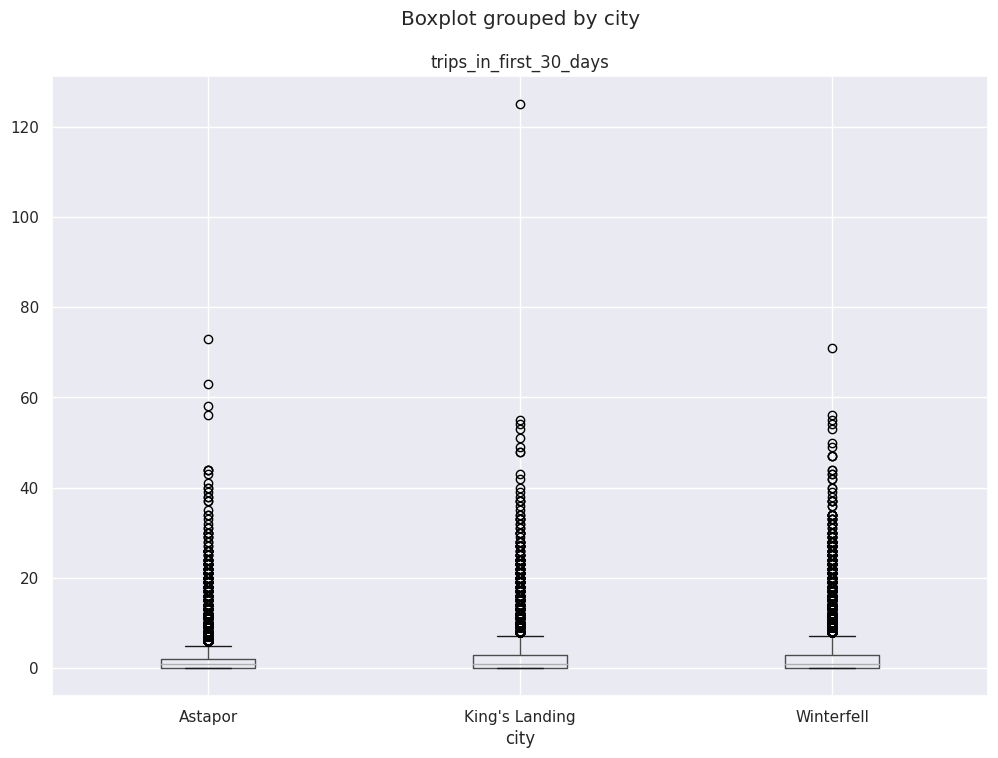

In [ ]:
#Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов?
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
df.boxplot(column = 'trips_in_first_30_days', by = 'city')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='first_trips_log', ylabel='Count'>

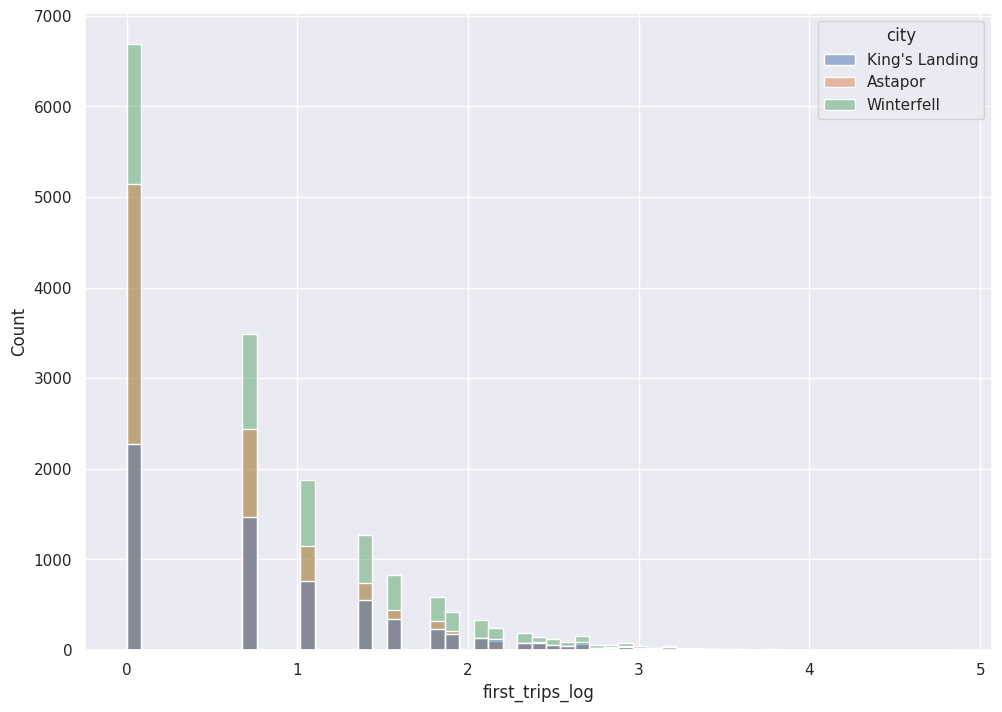

In [ ]:
df['first_trips_log'] = np.log(df['trips_in_first_30_days'])
df['first_trips_log'].unique()
sns.histplot(df, x = 'first_trips_log', hue = 'city')

In [ ]:
print(df.groupby('city').agg({'trips_in_first_30_days':'mean'}))
df.groupby('city').agg({'trips_in_first_30_days':'median'})
#т.к медианы не отличаются придется делать сравнения по средним

                trips_in_first_30_days
city                                  
Astapor                       1.948651
King's Landing                2.463672
Winterfell                    2.431179


,trips_in_first_30_days
city,
Astapor,1.0
King's Landing,1.0
Winterfell,1.0


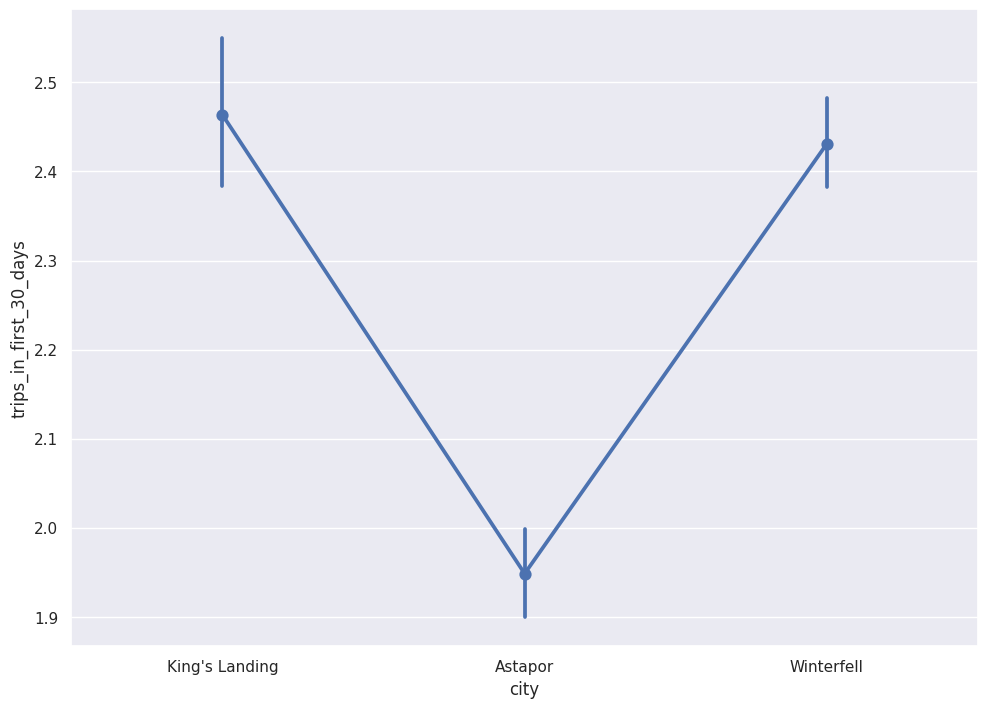

<Axes: xlabel='city', ylabel='trips_in_first_30_days'>

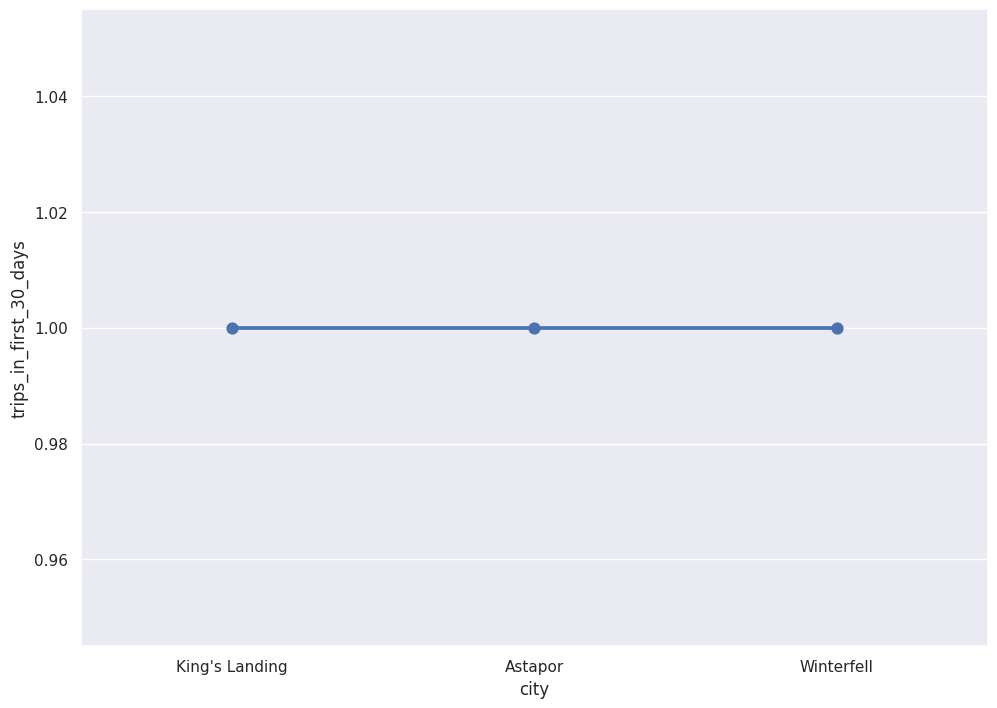

In [ ]:
#Ассиметричное распределение -> используем непараметрический аналог ANOVA, непараметрические попарные сравнения (распределение несимметрично, параметрические тесты не подойдут)
from scipy import stats
stats.kruskal(df[df['city'] == 'Astapor']['trips_in_first_30_days'], df[df['city'] == "King's Landing"]['trips_in_first_30_days'], df[df['city'] == "Winterfell"]['trips_in_first_30_days'])
#группы отличаются
sns.pointplot(df, x = 'city', y='trips_in_first_30_days')
plt.show()

In [ ]:
sp.posthoc_dunn(a = df, val_col = 'trips_in_first_30_days', group_col = 'city', p_adjust='bonferroni') #непараметрические попарные сравнения
#все группы различаются между собой по средним


,Astapor,King's Landing,Winterfell
Astapor,1.000000e+00,3.940849e-09,2.448501e-49
King's Landing,3.940849e-09,1.000000e+00,1.266032e-09
Winterfell,2.448501e-49,1.266032e-09,1.000000e+00


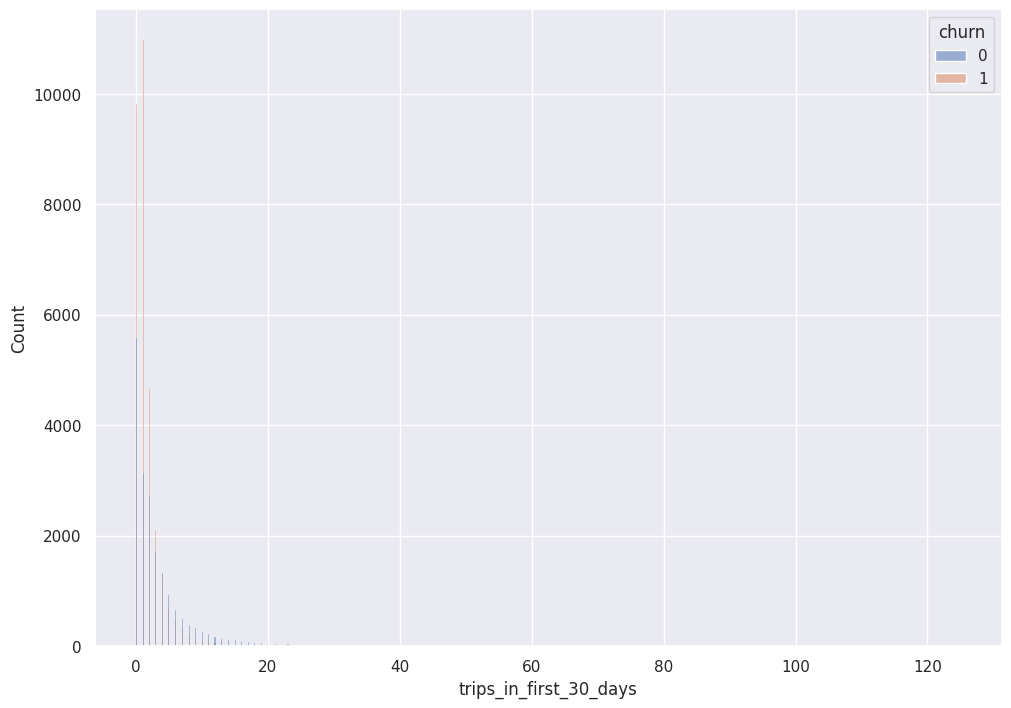

<Axes: xlabel='churn', ylabel='trips_in_first_30_days'>

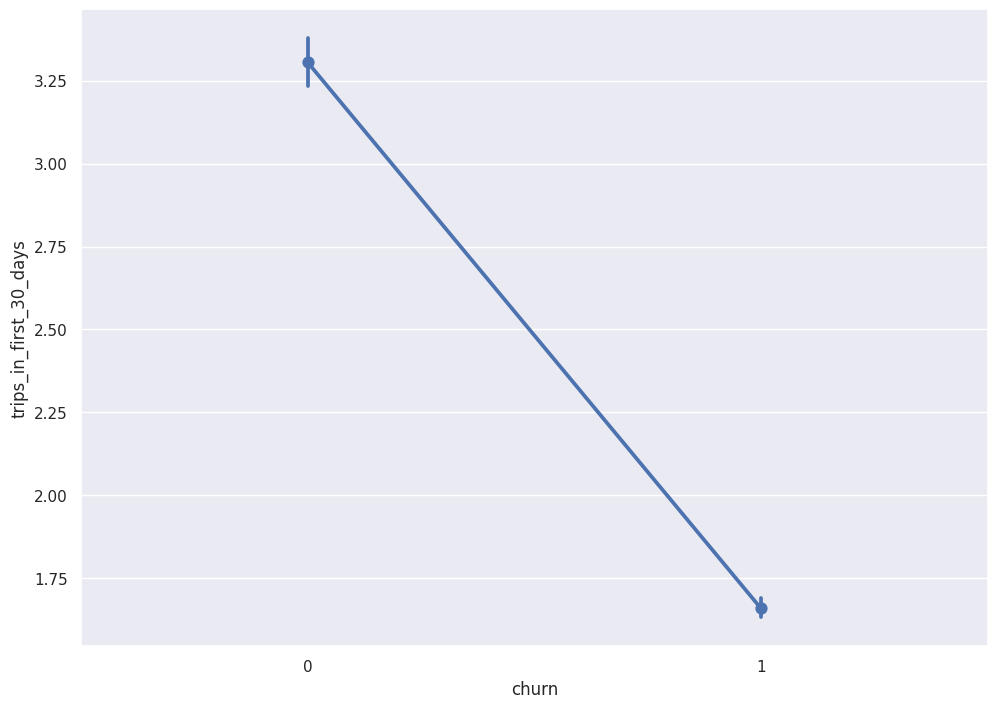

In [ ]:
# Может ли отток быть связан с активностью в первые 30 дней после регистрации?
sns.histplot(data = df, x = df['trips_in_first_30_days'], hue = 'churn')
plt.show()
sns.pointplot(df, x = 'churn', y='trips_in_first_30_days')
#судя по графикам те, кто совершал больше поездок первые 30 дней меньше уходили. Воспользуемся

In [ ]:
import scipy.stats as stats
stats.mannwhitneyu(df[df['churn'] == 0]['trips_in_first_30_days'], df[df['churn'] == 1]['trips_in_first_30_days'])
#группы значимо отличаются

MannwhitneyuResult(statistic=351842132.0, pvalue=0.0)